# Несколько практических задач для закрепления навыков построения нейросетей на Keras

## Задачи:

1. Задача регрессии (california housing)
2. Задача классификации (MNIST)
3. Задача восстановления изображений

## Нейросеть для California housing

#### 1.1. загрузим набор данных `fetch_california_housing` из `sklearn`.

In [29]:
from sklearn.datasets import fetch_california_housing
import pandas as pd


data = fetch_california_housing()

X = pd.DataFrame(data['data'], columns=data['feature_names'])
y = data['target']

In [30]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   MedInc      20640 non-null  float64
 1   HouseAge    20640 non-null  float64
 2   AveRooms    20640 non-null  float64
 3   AveBedrms   20640 non-null  float64
 4   Population  20640 non-null  float64
 5   AveOccup    20640 non-null  float64
 6   Latitude    20640 non-null  float64
 7   Longitude   20640 non-null  float64
dtypes: float64(8)
memory usage: 1.3 MB


In [31]:
X.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25


In [32]:
y

array([4.526, 3.585, 3.521, ..., 0.923, 0.847, 0.894])

#### 1.2. Разобъём данные на выборки для обучения и теста

In [33]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train,  y_test = train_test_split(X.values,y,test_size=0.2, random_state=10)
X_train.shape,  y_train.shape,X_test.shape,  y_test.shape

((16512, 8), (16512,), (4128, 8), (4128,))

#### 1.3. Создим архитектуру для этой задачи

сделаем сеть из двух слоев для быстрого обучения.

У первого слоя 8 входов по количеству признаков.

В результате нужно одно число - в последнем слое оставим один нейрон в котором будут "суммироваться" веса

In [34]:
from keras.layers import Dense 
from keras.models import Sequential
import tensorflow as tf
tf.random.set_seed(10)

model = Sequential([
        Dense(units=16, input_shape=(8,) , activation='relu'),
        #Dense(units=2, input_shape=(4,) , activation='relu'),
        Dense(units=1,  activation='relu')
        ])
model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_19 (Dense)            (None, 16)                144       
                                                                 
 dense_20 (Dense)            (None, 1)                 17        
                                                                 
Total params: 161
Trainable params: 161
Non-trainable params: 0
_________________________________________________________________


#### 1.4. Скомпилируем сеть

Для задачи регресси возмем функцию потерь mse и метрику mae.  

Вопользуемся оптимизатором - стахостичемским градиентным спуском

In [35]:
model.compile(optimizer='sgd', loss='mse', metrics='mae')

#### 1.5. Обучим нейросеть

In [36]:
%%time

model.fit(X_train,
          y_train, 
          epochs=5,
         # batch_size=64,       # Количество сэмплов за один шаг градиентного спуска
          steps_per_epoch=5,   # Общее количество шагов (батчей сэмплов) на одной эпохе.
                               # по умолчанию равняется количеству сэмплов в датасете деленное на batch size
          validation_split=0.2, # Доля обучающих данных, которая будет использоваться как валидационная часть 
        # validation_data=(X_test, y_test), #  Данные, на которых считается функция потерь и метрики в конце каждой эпохи
        # validation_batch_size=X_test.shape[0]  #  Количество сэмплов в один валидационный батч
          validation_freq=2  # столько эпох с обучением пройдет, до одной валидации
         )

Epoch 1/5
5/5 [==============================] - 0s 3ms/step - loss: 10.2644 - mae: 2.1886
Epoch 2/5
5/5 [==============================] - 0s 46ms/step - loss: 5.5723 - mae: 2.0622 - val_loss: 5.6388 - val_mae: 2.0740
Epoch 3/5
5/5 [==============================] - 0s 1ms/step - loss: 5.5723 - mae: 2.0622
Epoch 4/5
5/5 [==============================] - 0s 24ms/step - loss: 5.5723 - mae: 2.0622 - val_loss: 5.6388 - val_mae: 2.0740
Epoch 5/5
5/5 [==============================] - 0s 2ms/step - loss: 5.5723 - mae: 2.0622
Wall time: 586 ms


Сеть обучается плохо, так как данные не масштабированы.

#### 1.6. Отмасштабируем даные

In [40]:
from sklearn.preprocessing import MinMaxScaler

mms = MinMaxScaler()

X_train_n = mms.fit_transform(X_train)
X_test_n = mms.transform(X_test)

model = Sequential([
                  Dense(units=16, input_shape=(8,), activation='relu'),
                  Dense(units=12,  activation='relu'),
                  Dense(units=1, activation='relu')
])

model.compile(optimizer='sgd', loss='mse', metrics='mae')

# для будущей визулизации залогируем все измерения в объект history
history = model.fit(X_train_n, 
                    y_train, 
                    epochs=10,
                    #batch_size=64,
                    steps_per_epoch=10,
                    validation_split=0.2,
                    #validation_freq=2
                   )

Epoch 1/10
10/10 [==============================] - 0s 25ms/step - loss: 5.4805 - mae: 2.0415 - val_loss: 4.7279 - val_mae: 1.8522
Epoch 2/10
10/10 [==============================] - 0s 11ms/step - loss: 3.3284 - mae: 1.4252 - val_loss: 2.2014 - val_mae: 1.0661
Epoch 3/10
10/10 [==============================] - 0s 10ms/step - loss: 1.7670 - mae: 0.9576 - val_loss: 1.4929 - val_mae: 0.8976
Epoch 4/10
10/10 [==============================] - 0s 12ms/step - loss: 1.4183 - mae: 0.9043 - val_loss: 1.3758 - val_mae: 0.8968
Epoch 5/10
10/10 [==============================] - 0s 11ms/step - loss: 1.3430 - mae: 0.8985 - val_loss: 1.3170 - val_mae: 0.8852
Epoch 6/10
10/10 [==============================] - 0s 10ms/step - loss: 1.2936 - mae: 0.8859 - val_loss: 1.2762 - val_mae: 0.8746
Epoch 7/10
10/10 [==============================] - 0s 12ms/step - loss: 1.2569 - mae: 0.8752 - val_loss: 1.2413 - val_mae: 0.8638
Epoch 8/10
10/10 [==============================] - 0s 14ms/step - loss: 1.2235 - m

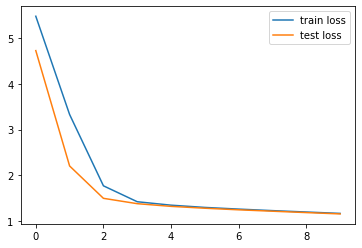

In [41]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='test loss')
plt.legend();

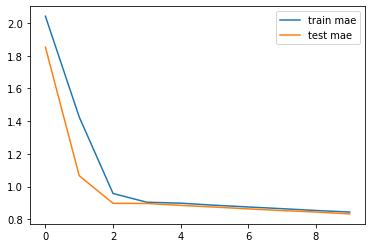

In [42]:
plt.plot(history.history['mae'], label='train mae')
plt.plot(history.history['val_mae'], label='test mae')
plt.legend();

как видим из графика - можно было обойтись меньшим количеством эпох так как с 4й эпохи значение ошибки изменяется не существенно

#### 1.7. Сделаем предсказания на тестовых данных

In [23]:
pred = model.predict(X_test_n)

129/129 [==============================] - 0s 915us/step


#### 1.8. Посчитаем метрику качества на тестовых данных

In [51]:
# в качествет метрик посмотри на r2  и среднюю абсолютную ошибку
from sklearn.metrics import r2_score, mean_absolute_error

round(r2_score(y_test, pred),3),  round(mean_absolute_error(y_test, pred),3)

(0.641, 0.485)

In [26]:
# сравним предсказанные значения с реальними
import pandas as pd
import numpy as np
pd.DataFrame({
    'true': np.squeeze(y_test[100:105]),
    'pred': np.squeeze(pred[100:105])
 })

,true,pred
0,2.113,2.069714
1,1.387,2.639574
2,2.343,2.763038
3,3.938,3.431436
4,1.598,2.025799


In [ ]:
Вывод: точность далека от идеальной, скорее всего нейросети требуется больше данных для обучения.

## 2. Нейросеть для MNIST

### 2.1. Загрузим набор данных `MNIST` из `keras` для задачи классификации рукописных цифр

In [76]:
import matplotlib.pyplot as plt # используем для вывода изображений

from keras.datasets import mnist
from keras.utils.np_utils import to_categorical # для категорирования таргета


(X_train, y_train), (X_test, y_test) = mnist.load_data()

X_train.shape, X_test.shape

((60000, 28, 28), (10000, 28, 28))

Выведем несколько примеров из обучения

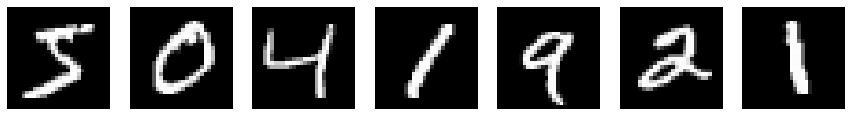

In [77]:
fig, ax = plt.subplots(1,7,figsize=(15,10))
for i in range(7):
    ax[i].imshow(X_train[i], cmap='gray')
    ax[i].axis('off')

In [78]:
pd.Series(y_train).value_counts()

1    6742
7    6265
3    6131
2    5958
9    5949
0    5923
6    5918
8    5851
4    5842
5    5421
dtype: int64

### 2.2. Подготовка данных

#### 2.2.1. Возьмём для обучения только два класса (3 и 8), чтобы сделать задачу бинарной классификации.

In [79]:
idxs = np.where((y_train == 3) | (y_train == 8))
y_train = y_train[idxs]
X_train = X_train[idxs]
X_train.shape ,y_train.shape

((11982, 28, 28), (11982,))

#### 2.2.2. Тоже самое сделаем для теста

In [80]:
idxs = np.where((y_test == 3) | (y_test == 8))
y_test = y_test[idxs]
X_test = X_test[idxs]
X_test.shape ,y_test.shape

((1984, 28, 28), (1984,))

#### 2.2.3. Выведем несколько изображений из новых данных

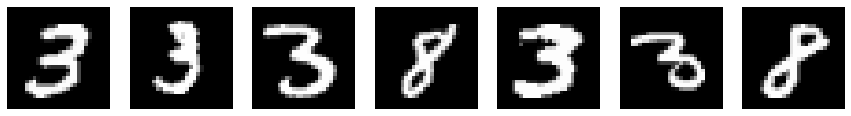

In [81]:
fig, ax = plt.subplots(1,7, figsize=(15,10))
for i in range(7):
    ax[i].imshow(X_train[i], cmap='gray')
    ax[i].axis('off')

#### 2.2.4. Нормируем данные

In [82]:
X_train = X_train / 255
X_test = X_test / 255
print(X_train.min(), X_train.max())

0.0 1.0


#### 2.2.5. Преобразуем целевые значения в бинарный вид

При этом еще нужно вначале перевести класс 3 и 8 в 0 и 1, только при таких метках класса сетка будет обучаться правильно.

In [83]:
y_train_cat = y_train
y_test_cat = y_test
y_train_cat[np.where(y_train == 3)] = 0
y_train_cat[np.where(y_train == 8)] = 1
y_test_cat[np.where(y_test == 3)] = 0
y_test_cat[np.where(y_test == 8)] = 1

In [84]:
y_train_cat = to_categorical(y_train_cat)
y_test_cat =  to_categorical(y_test_cat)

y_train_cat[:5]

array([[1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.]], dtype=float32)

#### 2.2.6. Уменьшение количества входных признаков

Уменьшим размер изображений для ускорения процесса обучения нейросети

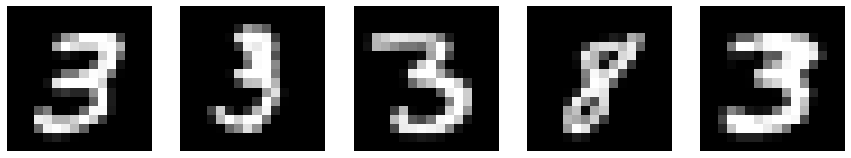

In [85]:
X_train_resized = tf.image.resize(X_train[..., np.newaxis], (16,16))[..., 0]
X_test_resized = tf.image.resize(X_test[..., np.newaxis], (16,16))[..., 0]

# посмотрим что получилось
fig, ax = plt.subplots(1,5, figsize=(15,10))
for i in range(5):
    ax[i].imshow(X_train_resized[i], cmap='gray')
    ax[i].axis('off')

### 2.3. Создадим архитектуру для этой задачи

In [87]:
from keras.layers import Flatten 
tf.random.set_seed(9)

model = Sequential([
                    Flatten(input_shape=(16,16)), # слой для преобразования входного изображения в одномерный вектор признаков
                    Dense(256, activation='relu'), # полносвязный слой с количеством нейронов по количеству пикселей
                    Dense(2, activation='sigmoid') # выходной слой с двумя нейронами которые с помощью сигмоиды будут выдавать вероятность принадледности к классам
])
model.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_1 (Flatten)         (None, 256)               0         
                                                                 
 dense_35 (Dense)            (None, 256)               65792     
                                                                 
 dense_36 (Dense)            (None, 2)                 514       
                                                                 
Total params: 66,306
Trainable params: 66,306
Non-trainable params: 0
_________________________________________________________________


### 2.4. Скомпилируем сеть

Подберём функцию потерь для классификации и метрику точности . Оптимизатор используем 'sgd'

In [90]:
model.compile(optimizer='sgd', loss='binary_crossentropy', metrics='accuracy')

### 2.5. Обучим нейросеть

In [92]:
model.fit(X_train_resized, y_train_cat, epochs=10)

Epoch 1/10
375/375 [==============================] - 1s 2ms/step - loss: 0.5139 - accuracy: 0.8456
Epoch 2/10
375/375 [==============================] - 1s 1ms/step - loss: 0.2833 - accuracy: 0.9236
Epoch 3/10
375/375 [==============================] - 0s 1ms/step - loss: 0.2064 - accuracy: 0.9383
Epoch 4/10
375/375 [==============================] - 0s 1ms/step - loss: 0.1731 - accuracy: 0.9463
Epoch 5/10
375/375 [==============================] - 0s 1ms/step - loss: 0.1544 - accuracy: 0.9503
Epoch 6/10
375/375 [==============================] - 0s 1ms/step - loss: 0.1430 - accuracy: 0.9534
Epoch 7/10
375/375 [==============================] - 0s 1ms/step - loss: 0.1348 - accuracy: 0.9562
Epoch 8/10
375/375 [==============================] - 0s 1ms/step - loss: 0.1288 - accuracy: 0.9586
Epoch 9/10
375/375 [==============================] - 0s 1ms/step - loss: 0.1240 - accuracy: 0.9599
Epoch 10/10
375/375 [==============================] - 0s 1ms/step - loss: 0.1202 - accuracy: 0.9613

Сеть обучается - ошибка падает, метрика становится лучше.

### 2.6. Сделаем предсказания на тестовых данных

In [93]:
pred = model.predict(X_test_resized)
preds_cls = pred.argmax(axis=1)  # отбираем класс с наибольшей предсказанной вероятностью

62/62 [==============================] - 0s 853us/step


### 2.7. Посчитаем метрику качества на тестовых данных

In [96]:
from sklearn.metrics import f1_score, accuracy_score

f1_score(y_test, preds_cls)

print(f'test acc: {accuracy_score(y_test, preds_cls)*100:.2f}% ({(y_test == preds_cls).sum()} out of {y_test.shape[0]})')

test acc: 96.82% (1921 out of 1984)


Вывод:  наша небольшая нейросеть способна не плохо классифицировать рукописные цифры даже на уменьшенных изображениях

## 3. Нейросеть для восстановления изображения

Будем работать с набором данным `fetch_olivetti_faces` из `sklearn`.

In [97]:
from sklearn.datasets import fetch_olivetti_faces
from sklearn.model_selection import train_test_split

data, _ = fetch_olivetti_faces(return_X_y=True)
train, test = train_test_split(data, test_size=0.2, random_state=4)

train.shape

downloading Olivetti faces from https://ndownloader.figshare.com/files/5976027 to C:\Users\Karlashov\scikit_learn_data


(320, 4096)

Сейчас изображение - это вектор 4096.

### 3.1. Работа с данными

#### 3.1.1. Переведём векторы в настоящие изображения из двух размерностей

In [99]:
train = train.reshape((train.shape[0],64,64))
test = test.reshape((test.shape[0],64,64))

#### 3.1.2. Выведем несколько примеров

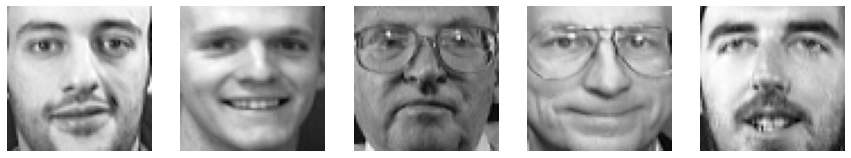

In [100]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1,5,figsize=(15,10))
for i in range(5):
    ax[i].imshow(train[i], cmap='gray')
    ax[i].axis('off')

Поделим данные на X и y, где X - это верхняя часть лица человека, на этом модель будет обучаться, а y - это нижняя часть лица человека - её будем предсказывать.

In [101]:
n_pixels = train.shape[1]

# Upper half of the faces
X_train = train[:, :(n_pixels + 1) // 2, :]
# Lower half of the faces
y_train = train[:, n_pixels // 2:, :]


X_test = test[:, :(n_pixels + 1) // 2, :]
y_test = test[:, n_pixels // 2:, :]

X_train.shape

(320, 32, 64)

Вот один пример обучающей пары.

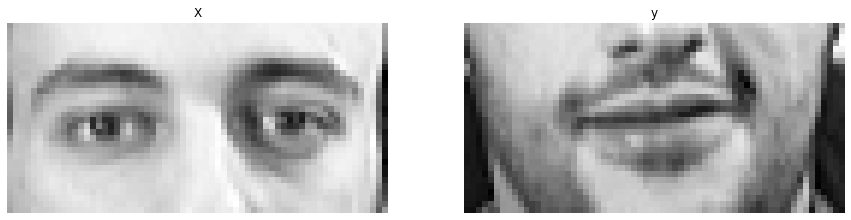

In [102]:
idx = 0

fig, ax = plt.subplots(1, 2, figsize=(15, 8))
ax[0].imshow(X_train[idx], cmap='gray')
ax[0].set_title('X')
ax[1].imshow(y_train[idx], cmap='gray')
ax[1].set_title('y')
ax[0].axis('off')
ax[1].axis('off')

plt.show()

#### 3.1.3. Изменим размерность y

Остается только изменить размерность y, т.к. сейчас $y$ - картинка 32x64, а выход нейронной сети у нас будет одномерный и равный 32 * 64 = 2048. 

In [103]:
y_train_n = y_train.reshape(y_train.shape[0], y_train.shape[1] * y_train.shape[2])
y_test_n = y_test.reshape(y_test.shape[0], y_test.shape[1] * y_test.shape[2])

### 3.2. Создим архитектуру для этой задачи

In [104]:
from keras.models import Sequential
from keras.layers import Flatten, Dense

model = Sequential([
                    Flatten(input_shape=(32,64)),
                    Dense(units=1024, activation='relu'),
                    Dense(units=1024, activation='relu'),
                    Dense(32 * 64, activation='linear')
])
model.summary()

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_2 (Flatten)         (None, 2048)              0         
                                                                 
 dense_37 (Dense)            (None, 1024)              2098176   
                                                                 
 dense_38 (Dense)            (None, 1024)              1049600   
                                                                 
 dense_39 (Dense)            (None, 2048)              2099200   
                                                                 
Total params: 5,246,976
Trainable params: 5,246,976
Non-trainable params: 0
_________________________________________________________________


### 3.3. Скомпилируем сеть

Подберём нужную функцию потерь и метрику. Оптимизатор используем 'adam'

In [107]:
model.compile(optimizer='adam', loss='mse', metrics='mae')

### 3.4. Обучим нейросеть

In [108]:
model.fit(X_train, y_train_n, epochs=400)

Epoch 1/400
10/10 [==============================] - 1s 25ms/step - loss: 0.1024 - mae: 0.2309
Epoch 2/400
10/10 [==============================] - 0s 24ms/step - loss: 0.0235 - mae: 0.1211
Epoch 3/400
10/10 [==============================] - 0s 25ms/step - loss: 0.0198 - mae: 0.1114
Epoch 4/400
10/10 [==============================] - 0s 26ms/step - loss: 0.0188 - mae: 0.1081
Epoch 5/400
10/10 [==============================] - 0s 26ms/step - loss: 0.0179 - mae: 0.1052
Epoch 6/400
10/10 [==============================] - 0s 26ms/step - loss: 0.0176 - mae: 0.1045
Epoch 7/400
10/10 [==============================] - 0s 26ms/step - loss: 0.0159 - mae: 0.0984
Epoch 8/400
10/10 [==============================] - 0s 27ms/step - loss: 0.0153 - mae: 0.0962
Epoch 9/400
10/10 [==============================] - 0s 26ms/step - loss: 0.0150 - mae: 0.0950
Epoch 10/400
10/10 [==============================] - 0s 26ms/step - loss: 0.0148 - mae: 0.0941
Epoch 11/400
10/10 [=============================

10/10 [==============================] - 0s 26ms/step - loss: 0.0043 - mae: 0.0483
Epoch 171/400
10/10 [==============================] - 0s 26ms/step - loss: 0.0043 - mae: 0.0481
Epoch 172/400
10/10 [==============================] - 0s 26ms/step - loss: 0.0042 - mae: 0.0479
Epoch 173/400
10/10 [==============================] - 0s 26ms/step - loss: 0.0043 - mae: 0.0487
Epoch 174/400
10/10 [==============================] - 0s 26ms/step - loss: 0.0045 - mae: 0.0499
Epoch 175/400
10/10 [==============================] - 0s 26ms/step - loss: 0.0047 - mae: 0.0507
Epoch 176/400
10/10 [==============================] - 0s 25ms/step - loss: 0.0048 - mae: 0.0515
Epoch 177/400
10/10 [==============================] - 0s 26ms/step - loss: 0.0046 - mae: 0.0502
Epoch 178/400
10/10 [==============================] - 0s 26ms/step - loss: 0.0044 - mae: 0.0490
Epoch 179/400
10/10 [==============================] - 0s 26ms/step - loss: 0.0043 - mae: 0.0489
Epoch 180/400
10/10 [=======================

10/10 [==============================] - 0s 25ms/step - loss: 0.0020 - mae: 0.0327
Epoch 339/400
10/10 [==============================] - 0s 25ms/step - loss: 0.0019 - mae: 0.0317
Epoch 340/400
10/10 [==============================] - 0s 27ms/step - loss: 0.0018 - mae: 0.0308
Epoch 341/400
10/10 [==============================] - 0s 25ms/step - loss: 0.0018 - mae: 0.0310
Epoch 342/400
10/10 [==============================] - 0s 26ms/step - loss: 0.0018 - mae: 0.0310
Epoch 343/400
10/10 [==============================] - 0s 26ms/step - loss: 0.0019 - mae: 0.0314
Epoch 344/400
10/10 [==============================] - 0s 26ms/step - loss: 0.0020 - mae: 0.0324
Epoch 345/400
10/10 [==============================] - 0s 26ms/step - loss: 0.0019 - mae: 0.0323
Epoch 346/400
10/10 [==============================] - 0s 26ms/step - loss: 0.0019 - mae: 0.0316
Epoch 347/400
10/10 [==============================] - 0s 26ms/step - loss: 0.0019 - mae: 0.0317
Epoch 348/400
10/10 [=======================

### 3.5. Сделаем предсказания на тестовых данных

In [109]:
pred = model.predict(X_test)
pred

3/3 [==============================] - 0s 6ms/step


array([[0.71541303, 0.7683622 , 0.78210783, ..., 0.12667082, 0.09284678,
        0.10205373],
       [0.4648984 , 0.50620145, 0.56721044, ..., 0.22696827, 0.22945875,
        0.22779588],
       [0.6508783 , 0.65585184, 0.7335694 , ..., 0.3462221 , 0.33622462,
        0.34837502],
       ...,
       [0.44013312, 0.48298636, 0.6294375 , ..., 0.17261443, 0.14370935,
        0.12958662],
       [0.5299386 , 0.53236073, 0.5152912 , ..., 0.3048519 , 0.30605274,
        0.35579598],
       [0.3163444 , 0.335088  , 0.3841216 , ..., 0.29632074, 0.16786677,
        0.13779338]], dtype=float32)

### 3.6. Посчитаем метрику качества на тестовых данных

In [110]:
from sklearn.metrics import mean_absolute_error

mean_absolute_error( pred,y_test_n)

0.07021687

### 3.7. Вернем размерность предсказанных векторов в двумерное изображение

In [112]:
pred_test = pred.reshape(pred.shape[0],32,64)
pred_test.shape

(80, 32, 64)

отрисуем все предсказания.

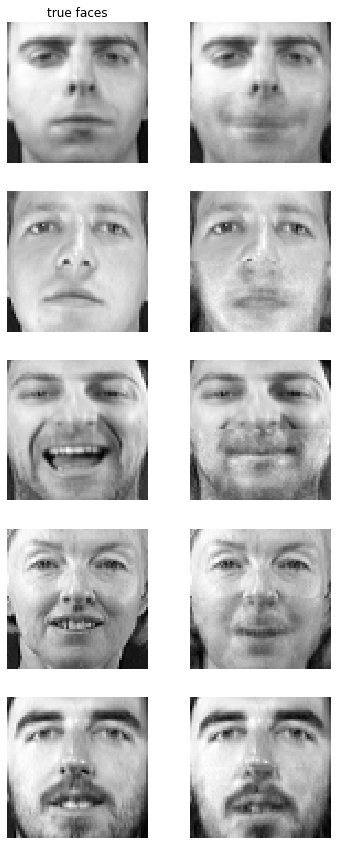

In [113]:
import numpy as np

n_faces = 5
n_cols = 2
image_shape = (64, 64)
plt.figure(figsize=(3 * n_cols, 3 * n_faces))


for i in range(5):
    true_face = np.vstack((X_test[i], y_test[i]))

    if i:
        sub = plt.subplot(n_faces, n_cols, i * n_cols + 1)
    else:
        sub = plt.subplot(n_faces, n_cols, i * n_cols + 1, title="true faces")

    sub.axis("off")
    sub.imshow(
        true_face.reshape(image_shape), cmap=plt.cm.gray, interpolation="nearest"
    )

    completed_face = np.vstack((X_test[i], pred_test[i]))

    if i:
        sub = plt.subplot(n_faces, n_cols, i * n_cols + 2)

    else:
        sub = plt.subplot(n_faces, n_cols, i * n_cols + 2)

    sub.axis("off")
    sub.imshow(
        completed_face.reshape(image_shape),
        cmap=plt.cm.gray,
        interpolation="nearest",
    )

С помощью нейросети попытались восстановить часть лица, это окнечнно баловсвто и выглядит часто крипово, но результат интересный - сетка смогла уловисть закономерность раположения тёмных пикселей в районе рта.